# CasADi vs. JAX

Author: Max Bloor

Benchmark a CasADi and JAX based dynamics model with neural network control to quantify the benefits of using either library. N.B. Both dynamics models are wrapped in the OpenAI gym environment.


In [1]:
import gymnasium as gym
from gymnasium import spaces
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import jax.numpy as jnp
from diffrax import ODETerm, Tsit5

## CasADi

In [46]:
class casadi_dyn(gym.Env):
    '''
    Class for CasADi gym environement
    '''
    
    def __init__(self):
        '''
        Constructor for the class
        '''
        self.Nx = 2 # Number of states
        self.Nu = 1 # Number of controls
        self.N = 25
        self.dt = 0.1
        self.x0 = torch.tensor([0.8,273])
        self.sym_x = self.gen_casadi_variable(self.Nx, "x")
        self.sym_u = self.gen_casadi_variable(self.Nu, "u")
        self.casadi_sym_model = self.casadify(cstr_ode, self.sym_x, self.sym_u)

        self.casadi_model_func = self.gen_casadi_function([self.sym_x, self.sym_u],[self.casadi_sym_model],
                                                          "model_func", ["x","u"], ["model_rhs"])
    
    def step(self, action):
        """
        Simulate one timestep of the environment

        Parameters
        ----------
        action : action taken by agent


        Returns
        -------
        state: array
            state of the system after timestep.
        rew : float
            reward obtained
        done : {0,1}
            0 if target not reached. 1 if reached
        info :

        """
    
        plant_func = self.casadi_model_func
        discretised_plant = self.discretise_model(plant_func, self.dt)

        xk = self.state[:self.Nx]

        Fk = discretised_plant(x0=xk.numpy(), p=action)
        
        self.state[:self.Nx] = torch.tensor(Fk['xf'].full()).reshape(self.Nx)
        
        
        rew = 0
        self.t += 1
        
        if self.t == self.N:
            done = True
        else:
            done = False

        return self.state, rew, done, False, {}

    def reset(self, seed=None):
        """
        Resets the state of the system and the noise generator

        Returns the state of the system
        """
        
        self.state = self.x0
        self.t = 0
        return self.state, {}
        
    def casadify(self, model, sym_x, sym_u):
        """
        Given a model with Nx states and Nu inputs and returns rhs of ode,
        return casadi symbolic model (Not function!)
        
        Inputs:
            model - model to be casidified i.e. a list of ode rhs of size Nx
            
        Outputs:
            dxdt - casadi symbolic model of size Nx of rhs of ode
        """

        dxdt = model(sym_x, sym_u)
        dxdt = vertcat(*dxdt) #Return casadi list of size Nx

        return dxdt



    def gen_casadi_variable(self, n_dim, name = "x"):
        """
        Generates casadi symbolic variable given n_dim and name for variable
        
        Inputs:
            n_dim - symbolic variable dimension
            name - name for symbolic variable
            
        Outputs:
            var - symbolic version of variable
        """

        var = SX.sym(name, n_dim)

        return var

    def gen_casadi_function(self, casadi_input, casadi_output, name, input_name=[], output_name=[]):
        """
        Generates a casadi function which maps inputs (casadi symbolic inputs) to outputs (casadi symbolic outputs)
        
        Inputs:
            casadi_input - list of casadi symbolics constituting inputs
            casadi_output - list of casadi symbolic output of function
            name - name of function
            input_name - list of names for each input
            output_name - list of names for each output
        
        Outputs:
            casadi function mapping [inputs] -> [outputs]
        
        """

        function = Function(name, casadi_input, casadi_output, input_name, output_name)

        return function
    def discretise_model(self, casadi_func, delta_t):
        """
        Input:
            casadi_func to be discretised
        
        Output:
            discretised casadi func
        """
        x = SX.sym("x", self.Nx)
        u = SX.sym("u", self.Nu)
        xdot = casadi_func(x, u)

        dae = {'x':x, 'p':u, 'ode':xdot} 
        opts = {'tf':delta_t}
        discrete_model = integrator('discrete_model', 'cvodes', dae, opts)

        return discrete_model
def cstr_ode(x,u):
    #defines cstr ode model 

    ###Parameters### (May want to pass these externally)
    q = 100 #m3/s
    V = 100 #m3
    rho = 1000 #kg/m3
    C = 0.239 #Joules/kg K
    deltaHr = -5e4 #Joules/kg K
    EA_over_R = 8750 #K 
    k0 = 7.2e10 #1/sec
    UA = 5e4 # W/K
    Ti = 350 #K
    caf = 1

    ###Model equations###
    ca,T = x[0],x[1]
    Tc = u[0]

    rA = k0 * np.exp(-EA_over_R/T)*ca
    dxdt = [
        q/V*(caf-ca) - rA,
        q/V*(Ti-T) + ((-deltaHr)*rA)*(1/(rho*C)) + UA*(Tc-T)*(1/(rho*C*V))]
    return dxdt
        

### Simulate CasADi with constant Action

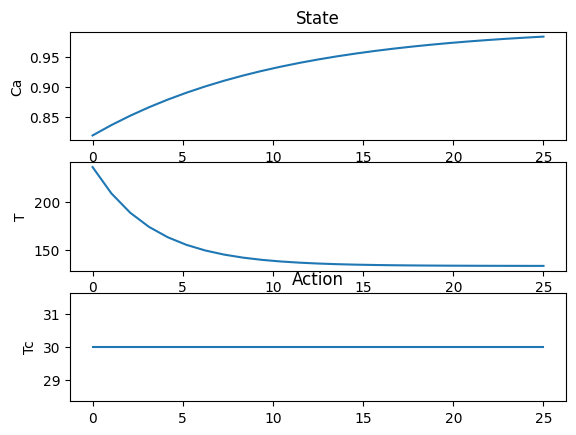

In [73]:
# Set up gym environment
env = casadi_dyn()
x0,_ = env.reset()
states = np.zeros((25,2))
states[0,:] =x0

#Closed-loop Simulation
for i in range(25):
    a = 30
    state, rew, done, _, _ = env.step(a)
    states[i,:] =state
    if done:
        break

#Plot
t = np.linspace(0,25,len(states))
plt.figure()
plt.subplot(311)
plt.title('State')
plt.plot(t,states[:,0])
plt.ylabel('Ca')
plt.subplot(312)
plt.plot(t,states[:,1])
plt.ylabel('T')
plt.subplot(313)
plt.title('Action')
plt.plot(t,np.ones(t.shape[0])*a)
plt.ylabel('Tc')
plt.show()

### CasADi with NN Controller

In [82]:
class CasADi_Controller(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, custom_weights=None):
        super(CasADi_Controller, self).__init__()

        # Use the provided custom weights as real numbers
        self.fc1_weight = nn.Parameter(custom_weights['fc1_weight'])
        self.fc1_bias = nn.Parameter(custom_weights['fc1_bias'])
        self.fc2_weight = nn.Parameter(custom_weights['fc2_weight'])
        self.fc2_bias = nn.Parameter(custom_weights['fc2_bias'])

    def forward(self, x):
        x = torch.matmul(self.fc1_weight, x) + self.fc1_bias
        x = torch.relu(x)
        x = torch.matmul(self.fc2_weight, x) + self.fc2_bias
        return x


input_size = 2
hidden_size = 32
output_size = 1

# Define custom weights and biases as real numbers
custom_weights = {
    'fc1_weight': torch.tensor([[0.5, -0.3], [0.2, 0.1]], dtype=torch.float32),  
    'fc1_bias': torch.tensor([0.1, -0.2], dtype=torch.float32),  
    'fc2_weight': torch.tensor([[0.3, 0.4]], dtype=torch.float32),  
    'fc2_bias': torch.tensor([0.5], dtype=torch.float32)  
}
model = CasADi_Controller(input_size, hidden_size, output_size, custom_weights)



Elapsed time: 0.049 seconds


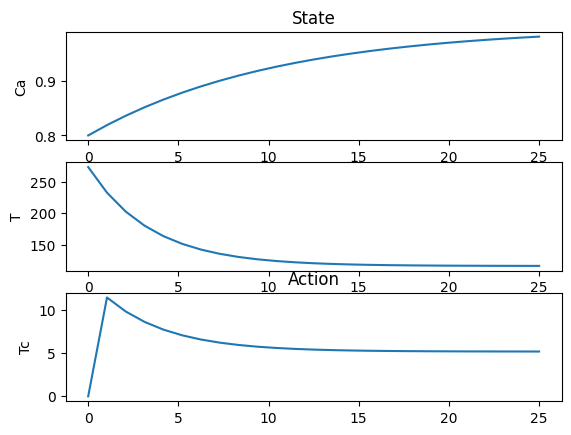

In [96]:
# Set up gym environment
env = casadi_dyn()
x0,_ = env.reset()
states = np.zeros((25,2))
states[0,:] =x0
actions = np.zeros(25)

#Closed-loop Simulation
s_time = time.time()
for i in range(24):
    a = model(torch.tensor(states[i,:],dtype=torch.float32))
    state, rew, done, _, _ = env.step(a.detach().numpy())
    states[i+1,:] = state

    actions[i+1] = a[0].detach().numpy()
e_time = time.time()

# Calculate the elapsed time
elapsed_time = e_time - s_time

print(f"Elapsed time: {np.round(elapsed_time,4)} seconds")

#Plot
t = np.linspace(0,25,len(states))
plt.figure()
plt.subplot(311)
plt.title('State')
plt.plot(t,states[:,0])
plt.ylabel('Ca')
plt.subplot(312)
plt.plot(t,states[:,1])
plt.ylabel('T')
plt.subplot(313)
plt.title('Action')
plt.plot(t,actions)
plt.ylabel('Tc')
plt.show()

## JAX

In [49]:
class JAX_dyn(gym.Env):
    '''
    Class for JAX gym environement
    '''
    
    def __init__(self):
        '''
        Constructor for the class
        '''
        self.Nx = 2 # Number of states
        self.Nu = 1 # Number of controls
        self.N = 25
        self.dt = 0.1
          
        self.term = ODETerm(react)
        self.solver = Tsit5()
        self.t0 = 0
        self.dt0 = self.dt
      
    
    def step(self, action):
        """
        Simulate one timestep of the environment

        Parameters
        ----------
        action : action taken by agent


        Returns
        -------
        state: array
            state of the system after timestep.
        rew : float
            reward obtained
        done : {0,1}
            0 if target not reached. 1 if reached
        info :

        """
        args = (100, 100, 1000, 0.239, -5e4, 8750, 7.2e10, 5e4, 350, 1, action) 
        self.y, _, _, self.state, _ = self.solver.step(self.term, self.tprev, self.tnext, self.y, args, self.state, made_jump=False)
        self.tprev = self.tnext
        self.tnext = min(self.tprev + self.dt, self.N)
        
        if self.tnext == self.N:
            done = True
        else:
            done = False
        rew = 0
        return self.y, rew, done, False, {}

    def reset(self, seed=None):
        """
        Resets the state of the system and the noise generator

        Returns the state of the system
        """
        t0 = 0
        dt0 = 0.1
        
        args = (100, 100, 1000, 0.239, -5e4, 8750, 7.2e10, 5e4, 350, 1, 280) 

        self.tprev = t0
        self.tnext = t0 + dt0
        self.y = jnp.array([0.1, 370.0]) 
        self.state = self.solver.init(self.term, self.tprev, self.tnext, self.y, args)
        return self.state, {}
        
   
def react(t, y, args):
    Ca, T = y
    q, V, rho, C, deltaHr, EA_over_R, k0, UA, Ti, caf, Tc = args
   
    rA = k0 * jnp.exp(-EA_over_R / T) * Ca
    d_Ca = q/V * (caf - Ca) - rA
    d_T = q/V * (Ti - T) + ((-deltaHr) * rA) * (1 / (rho * C)) + UA * (Tc - T) * (1 / (rho * C * V))
   
    d_y = jnp.array([d_Ca, d_T])  # Return a flat array of derivatives
    return d_y
        

### Simulate JAX with Constant Action

Elapsed time: 5.6047 seconds


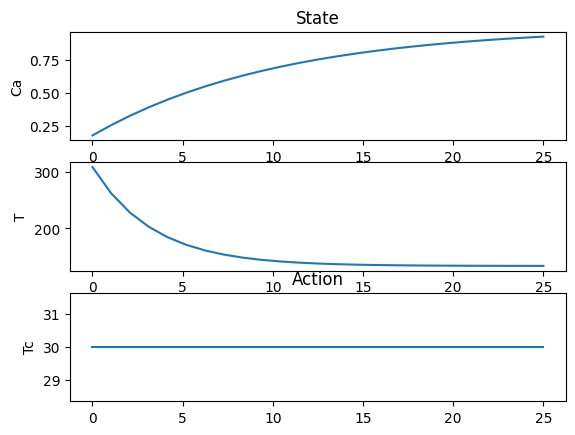

In [52]:
# Set up gym environment
env = JAX_dyn()
x0,_ = env.reset()

states[0,:] =x0[1]


#Closed-loop Simulation
s_time = time.time()
for i in range(25):
    a = 30
    state, rew, done, _, _ = env.step(a)
    states[i,:] =state
    if done:
        break
e_time = time.time()

# Calculate the elapsed time
elapsed_time = e_time - s_time

print(f"Elapsed time: {np.round(elapsed_time,4)} seconds")
#Plot
t = np.linspace(0,25,len(states))
plt.figure()
plt.subplot(311)
plt.title('State')
plt.plot(t,states[:,0])
plt.ylabel('Ca')
plt.subplot(312)
plt.plot(t,states[:,1])
plt.ylabel('T')
plt.subplot(313)
plt.title('Action')
plt.plot(t,np.ones(t.shape[0])*a)
plt.ylabel('Tc')
plt.show()

### JAX Dynamic model with NN (FLAX) controller

In [25]:

term = ODETerm(react)
solver = Tsit5()

t0 = 0
dt0 = 0.05
t1 = 1

args = (100, 100, 1000, 0.239, -5e4, 8750, 7.2e10, 5e4, 350, 1, 280) 

tprev = t0
tnext = t0 + dt0
y0 = jnp.array([0.1, 370.0]) 
state = solver.init(term, tprev, tnext, y0, args)


def react(t, y, args):
    Ca, T = y
    q, V, rho, C, deltaHr, EA_over_R, k0, UA, Ti, caf, Tc = args
   
    rA = k0 * jnp.exp(-EA_over_R / T) * Ca
    d_Ca = q/V * (caf - Ca) - rA
    d_T = q/V * (Ti - T) + ((-deltaHr) * rA) * (1 / (rho * C)) + UA * (Tc - T) * (1 / (rho * C * V))
   
    d_y = jnp.array([d_Ca, d_T])  # Return a flat array of derivatives
    return d_y
        
while tprev < t1:
    y, _, _, state, _ = solver.step(term, tprev, tnext, y, args, state, made_jump=False)
    print(f"At time {tnext} obtained value {y}")
    tprev = tnext
    tnext = min(tprev + dt0, t1)

At time 0.05 obtained value [8.3764344e-02 1.5996890e+02]
At time 0.1 obtained value [1.2844969e-01 1.8040555e+02]
At time 0.15000000000000002 obtained value [1.7095570e-01 1.9791475e+02]
At time 0.2 obtained value [2.1138866e-01 2.1291588e+02]
At time 0.25 obtained value [  0.24984968 225.76816   ]
At time 0.3 obtained value [  0.2864349 236.77945  ]
At time 0.35 obtained value [  0.32123563 246.21346   ]
At time 0.39999999999999997 obtained value [  0.3543385 254.2962   ]
At time 0.44999999999999996 obtained value [  0.38582528 261.2215    ]
At time 0.49999999999999994 obtained value [  0.4157729 267.1555   ]
At time 0.5499999999999999 obtained value [  0.44425336 272.2408    ]
At time 0.6 obtained value [  0.47133413 276.5998    ]
At time 0.65 obtained value [  0.49707842 280.33752   ]
At time 0.7000000000000001 obtained value [  0.52154595 283.54407   ]
At time 0.7500000000000001 obtained value [  0.5447934 286.29657  ]
At time 0.8000000000000002 obtained value [  0.5668753 288.661